In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torchinfo import summary

import matplotlib.pyplot as plt

import os

from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_dir = "../data/archive/train/train/"
test_dir = "../data/archive/test/test/"

In [4]:
for i in os.listdir(train_dir):
    # print(f"{train_dir}/{i}")
    old_path = train_dir+"/"+i
    cat = "../data/data/train/cat/"
    dog = "../data/data/train/dog/"
    if "dog" in i:
        os.rename(old_path,dog+i)
    else:
        os.rename(old_path,cat+i)
        

In [5]:
data_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.ColorJitter(),
    transforms.RandomRotation(degrees=15)
])

In [6]:
train_dir = "../data/data/train/"
test_dir = "../data/data/test1/"

In [7]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 17498
     Root location: ../data/data/train/
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
            ),
 Dataset ImageFolder
     Number of datapoints: 7501
     Root location: ../data/data/test1/
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
      

In [8]:
class_names = train_data.classes
class_names

['cat', 'dog']

In [9]:
class_dict = train_data.class_to_idx
class_dict

{'cat': 0, 'dog': 1}

In [10]:
len(train_data), len(test_data)

(17498, 7501)

In [11]:
batch_size = 64

In [12]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1935cd56b50>,
 <torch.utils.data.dataloader.DataLoader at 0x1935cd5ca00>)

In [13]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 128, 128])

In [14]:
next(iter(train_dataloader))[1].shape

torch.Size([64])

In [15]:
class dogvscatv0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()

        self.conv2d_1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2d_2 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(in_features=hidden_units * 32 * 32, out_features=output_shape)

    def forward(self, x):
        z = self.conv2d_1(x)
        z = self.relu(z)
        z = self.conv2d_2(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.conv2d_2(z)
        z = self.relu(z)
        z = self.conv2d_2(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.flatten(z)
        z = self.linear_1(z)

        return z

In [16]:
model_1 = dogvscatv0(input_shape=3,
                   hidden_units=10,
                   output_shape=1).to(device)

In [17]:
model_1

dogvscatv0(
  (conv2d_1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2d_2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=10240, out_features=1, bias=True)
)

In [18]:
summary(model_1, input_size=[32,3,128,128])

Layer (type:depth-idx)                   Output Shape              Param #
dogvscatv0                               [32, 1]                   --
├─Conv2d: 1-1                            [32, 10, 128, 128]        280
├─ReLU: 1-2                              [32, 10, 128, 128]        --
├─Conv2d: 1-3                            [32, 10, 128, 128]        910
├─ReLU: 1-4                              [32, 10, 128, 128]        --
├─MaxPool2d: 1-5                         [32, 10, 64, 64]          --
├─Conv2d: 1-6                            [32, 10, 64, 64]          (recursive)
├─ReLU: 1-7                              [32, 10, 64, 64]          --
├─Conv2d: 1-8                            [32, 10, 64, 64]          (recursive)
├─ReLU: 1-9                              [32, 10, 64, 64]          --
├─MaxPool2d: 1-10                        [32, 10, 32, 32]          --
├─Flatten: 1-11                          [32, 10240]               --
├─Linear: 1-12                           [32, 1]                 

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

In [20]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [21]:
torch.manual_seed(42)

epochs = 3

for epoch in range(epochs):

    # training

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(train_dataloader):

        X = X.to(device)
        y = y.to(device)

        y = y.float()

        model_1.train()

        train_pred = model_1(X).squeeze()

        loss = loss_fn(train_pred, y)
        train_loss += loss

        acc = accuracy_fn(y_true=y,
                          y_pred=torch.round(torch.sigmoid(train_pred)))
        train_acc += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)


    #testing

    test_loss = 0
    test_acc = 0

    model_1.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:

            X = X.to(device)
            y = y.to(device)

            y = y.float()

            test_pred = model_1(X).squeeze()

            loss = loss_fn(test_pred, y)
            test_loss += loss

            acc = accuracy_fn(y_true = y,
                              y_pred = torch.round(torch.sigmoid(test_pred)))
            test_acc += acc

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}%")


Train loss: 0.69326 | Train accuracy: 50.35356% | Test loss: 0.69341 | Test accuracy: 50.34428%

Train loss: 0.69331 | Train accuracy: 49.73417% | Test loss: 0.69311 | Test accuracy: 50.34428%

Train loss: 0.69328 | Train accuracy: 49.98816% | Test loss: 0.69324 | Test accuracy: 49.65572%


In [28]:
class dogvscatv2(nn.Module):
    def __init__(self, input_shape: int, hidden_units:int, output_shape: int):
        super().__init__()

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.conv2d_1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1)
        self.conv2d_2 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1)
        self.conv2d_3 = nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*3, kernel_size=3, stride=1, padding=1)
        self.conv2d_4 = nn.Conv2d(in_channels=hidden_units*3, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(in_features=hidden_units*4*(32*32), out_features=output_shape)

    def forward(self, x):

        z = self.conv2d_1(x)
        z = self.relu(z)
        z = self.conv2d_2(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.conv2d_3(z)
        z = self.relu(z)
        z = self.conv2d_4(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.flatten(z)
        z = self.linear_1(z)

        return z

In [29]:
model_2 = dogvscatv2(input_shape=3,
                     hidden_units=10,
                     output_shape=1).to(device)
model_2

dogvscatv2(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv2d_1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_4): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=40960, out_features=1, bias=True)
)

In [30]:
summary(model_2, input_size=[64, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
dogvscatv2                               [64, 1]                   --
├─Conv2d: 1-1                            [64, 10, 128, 128]        280
├─ReLU: 1-2                              [64, 10, 128, 128]        --
├─Conv2d: 1-3                            [64, 20, 128, 128]        1,820
├─ReLU: 1-4                              [64, 20, 128, 128]        --
├─MaxPool2d: 1-5                         [64, 20, 64, 64]          --
├─Conv2d: 1-6                            [64, 30, 64, 64]          5,430
├─ReLU: 1-7                              [64, 30, 64, 64]          --
├─Conv2d: 1-8                            [64, 40, 64, 64]          10,840
├─ReLU: 1-9                              [64, 40, 64, 64]          --
├─MaxPool2d: 1-10                        [64, 40, 32, 32]          --
├─Flatten: 1-11                          [64, 40960]               --
├─Linear: 1-12                           [64, 1]                   40,961


In [31]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [32]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [38]:
torch.manual_seed(42)

epochs = 3

for epoch in range(epochs):

    # training

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(train_dataloader):

        X = X.to(device)
        y = y.to(device)

        y = y.float()

        model_2.train()

        train_pred = model_2(X).squeeze()

        loss = loss_fn(train_pred, y)
        train_loss += loss

        acc = accuracy_fn(y_true=y,
                          y_pred=torch.round(torch.sigmoid(train_pred)))
        train_acc += acc
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # testing

    test_loss = 0
    test_acc = 0

    model_2.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:

            X = X.to(device)
            y = y.to(device)

            y = y.float()

            test_pred = model_2(X).squeeze()

            loss = loss_fn(test_pred, y)
            test_loss += loss

            acc = accuracy_fn(y_true=y,
                              y_pred=torch.round(torch.sigmoid(test_pred)))
            test_acc += acc

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}%")




Train loss: 0.69316 | Train accuracy: 50.29653% | Test loss: 0.69209 | Test accuracy: 50.35752%

Train loss: 0.69052 | Train accuracy: 53.80887% | Test loss: 0.68977 | Test accuracy: 52.01373%

Train loss: 0.68623 | Train accuracy: 55.82450% | Test loss: 0.68560 | Test accuracy: 53.41529%


In [39]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x19342b699d0>,
 <torch.utils.data.dataloader.DataLoader at 0x19342b69e20>)

In [40]:
class dogvscatv3(nn.Module):
    def __init__(self, input_shape: int, hidden_units:int, output_shape: int):
        super().__init__()

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.conv2d_1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1)
        self.conv2d_2 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1)
        self.conv2d_3 = nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*3, kernel_size=3, stride=1, padding=1)
        self.conv2d_4 = nn.Conv2d(in_channels=hidden_units*3, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(in_features=hidden_units*4*(32*32), out_features=output_shape)

    def forward(self, x):

        z = self.conv2d_1(x)
        z = self.relu(z)
        z = self.conv2d_2(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.conv2d_3(z)
        z = self.relu(z)
        z = self.conv2d_4(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.flatten(z)
        z = self.linear_1(z)

        return z

In [41]:
model_3 = dogvscatv2(input_shape=3,
                     hidden_units=10,
                     output_shape=1).to(device)
model_3

dogvscatv2(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv2d_1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_4): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=40960, out_features=1, bias=True)
)

In [45]:
summary(model_3, input_size=[32, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
dogvscatv2                               [32, 1]                   --
├─Conv2d: 1-1                            [32, 10, 128, 128]        280
├─ReLU: 1-2                              [32, 10, 128, 128]        --
├─Conv2d: 1-3                            [32, 20, 128, 128]        1,820
├─ReLU: 1-4                              [32, 20, 128, 128]        --
├─MaxPool2d: 1-5                         [32, 20, 64, 64]          --
├─Conv2d: 1-6                            [32, 30, 64, 64]          5,430
├─ReLU: 1-7                              [32, 30, 64, 64]          --
├─Conv2d: 1-8                            [32, 40, 64, 64]          10,840
├─ReLU: 1-9                              [32, 40, 64, 64]          --
├─MaxPool2d: 1-10                        [32, 40, 32, 32]          --
├─Flatten: 1-11                          [32, 40960]               --
├─Linear: 1-12                           [32, 1]                   40,961


In [46]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.01)

In [47]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [48]:
torch.manual_seed(42)

epochs = 3

for epoch in range(epochs):

    # training

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(train_dataloader):

        X = X.to(device)
        y = y.to(device)

        y = y.float()

        model_3.train()

        train_pred = model_2(X).squeeze()

        loss = loss_fn(train_pred, y)
        train_loss += loss

        acc = accuracy_fn(y_true=y,
                          y_pred=torch.round(torch.sigmoid(train_pred)))
        train_acc += acc
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # testing

    test_loss = 0
    test_acc = 0

    model_3.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:

            X = X.to(device)
            y = y.to(device)

            y = y.float()

            test_pred = model_2(X).squeeze()

            loss = loss_fn(test_pred, y)
            test_loss += loss

            acc = accuracy_fn(y_true=y,
                              y_pred=torch.round(torch.sigmoid(test_pred)))
            test_acc += acc

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}%")




Train loss: 0.68405 | Train accuracy: 53.88219% | Test loss: 0.68482 | Test accuracy: 53.87582%

Train loss: 0.68410 | Train accuracy: 53.99469% | Test loss: 0.68511 | Test accuracy: 54.04869%

Train loss: 0.68408 | Train accuracy: 54.01315% | Test loss: 0.68522 | Test accuracy: 53.60986%


In [66]:
img, label = next(iter(train_dataloader))
img, label

(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.00

In [69]:
mo = model_3(img[0].unsqueeze(dim=0).to(device)).squeeze()
mo

tensor(-0.0150, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [70]:
mo.dtype

torch.float32

In [71]:
la = label[0].to(device).float()
la.dtype

torch.float32

In [72]:
type(mo.data)

torch.Tensor

In [73]:
type(label[0].to(device).data)

torch.Tensor

In [74]:
loss_fn(mo, la)

tensor(0.7007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

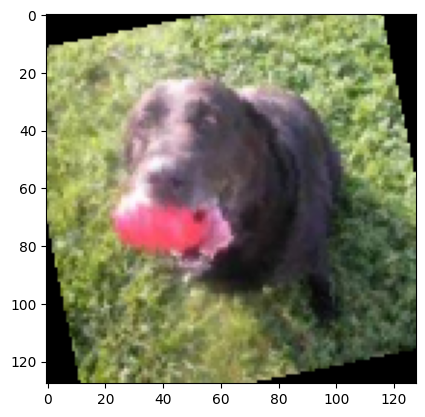

In [75]:
img_transposed = img[4].permute((1, 2, 0))
plt.imshow(img_transposed)

In [76]:
img[3], label[3]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor(1))

In [77]:
model_3(img[3].unsqueeze(dim=0).to(device))

tensor([[0.0072]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [78]:
torch.sigmoid(model_3(img[3].unsqueeze(dim=0).to(device)))

tensor([[0.5018]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [79]:
accuracy_fn(y_true=label[3],
            y_pred=torch.round(torch.sigmoid(model_3(img[0].unsqueeze(dim=0).to(device)))))

0.0

In [80]:
imgpath = "../data/data/test/15.jpg"

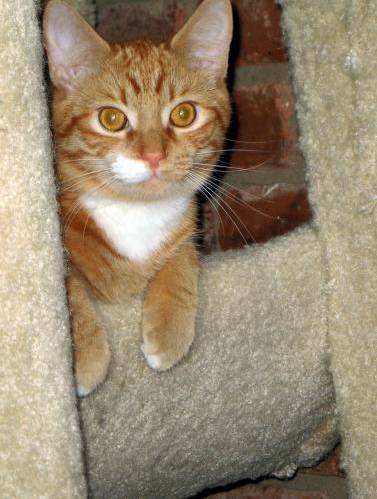

In [81]:
Image.open(imgpath)

In [82]:
torch.round(
    torch.sigmoid(
        model_3(
            data_transform(
                Image.open(
                    imgpath
                    )
                    ).unsqueeze(dim=0).to(device))))

tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [83]:
torch.round(torch.tensor(0.1))

tensor(0.)

In [84]:
for x, y in test_dataloader:
    print(y)
    print(type(y.unsqueeze(dim=1)))
    print(y.unsqueeze(dim=1).float())
    print(type(y.unsqueeze(dim=1).float()))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
<class 'torch.Tensor'>
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
<class 'torch.Tensor'>
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
<class 'torch.Tensor'>
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
    